# Dataset Description and Structure

## Dataset Description

The dataset is from a study that collected data from young adults in the UK with type 1 diabetes, who used a continuous glucose monitor (CGM), an insulin pump and a smartwatch.
These devices collected blood glucose readings, insulin dosage, carbohydrate intake, and activity data. The data collected was aggregated to five-minute intervals and formatted
into samples. Each sample represents a point in time and includes the aggregated five-minute intervals from the previous six hours. The aim is to predict the blood glucose reading
an hour into the future, for each of these samples.

The training set takes samples from the first three months of study data from nine of the participants and includes the future blood glucose value. These training samples appear in
chronological order and overlap. The testing set takes samples from the remainder of the study period from fifteen of the participants (so unseen participants appear in the testing
set). These testing samples do not overlap and are in a random order to avoid data leakage.

Complexities to be aware of:

* this is medical data so there are missing values and noise in the data
* the participants did not all use the same device models (CGM, insulin pump and smartwatch) so there may be differences in the collection method of the data
* some participants in the test set do not appear in the training set

### File descriptions

* activities.txt - a list of activity names that appear in the activity-X:XX columns
* sample_submission.csv - a sample submission file in the correct format
* test.csv - the test set
* train.csv - the training set

### Columns

| #Column | Name   | Description                                                                                     | Type   | 
|---------|---------------|-------------------------------------------------------------------------------------------------|--------|
| 1       | id            | row id consisting of participant number and a count for that participant                        | string |
| 2       | p_num         | participant number                                                                              | string |
| 3       | time          | time of day in the format HH:MM:SS                                                              | string |
| 4-75    | bg-X:XX       | blood glucose reading in mmol/L, X:XX(H:MM) time in the past                                    | float  |
| 76-147  | insulin-X:XX  | total insulin dose received in units in the last 5 minutes, X:XX(H:MM) time in the past         | float  |
| 148-219 | carbs-X:XX    | total carbohydrate value consumed in grammes in the last 5 minutes, X:XX(H:MM) time in the past | float  |
| 220-291 | hr-X:XX       | mean heart rate in beats per minute in the last 5 minutes, X:XX(H:MM) time in the past          | float  |
| 292-363 | steps-X:XX    | total steps walked in the last 5 minutes, X:XX(H:MM) time in the past                           | float  |
| 364-435 | cals-X:XX     | total calories burnt in the last 5 minutes, X:XX(H:MM) time in the past                         | string |
| 436-507 | activity-X:XX | self-declared activity performed in the last 5 minutes, X:XX(H:MM) time in the past             | string |
| 508     | bg-X:XX+1     | blood glucose reading in mmol/L, X:XX+1(H:MM) time in the future, not provided in test.csv      | float  |


## Dataset Structure

In [1]:
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns

### Compare the training and test data

We want to check if there are any differences between the two datasets columns.

In [2]:
# read train and test data
df_train = pd.read_csv(os.path.join('..', '..', '..', 'data', 'raw', 'train.csv'), low_memory=False)
df_test = pd.read_csv(os.path.join('..', '..', '..', 'data', 'raw', 'test.csv'), low_memory=False)

In [3]:
set(df_train.columns) - set(df_test.columns)
print(f'Columns in train but not in test: {list(set(df_train.columns) - set(df_test.columns))}')

Columns in train but not in test: ['bg+1:00']


In [4]:
df_train.head()

,id,p_num,time,bg-5:55,bg-5:50,bg-5:45,bg-5:40,bg-5:35,bg-5:30,bg-5:25,...,activity-0:40,activity-0:35,activity-0:30,activity-0:25,activity-0:20,activity-0:15,activity-0:10,activity-0:05,activity-0:00,bg+1:00
0,p01_0,p01,06:10:00,NaN,NaN,9.6,NaN,NaN,9.7,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.4
1,p01_1,p01,06:25:00,NaN,NaN,9.7,NaN,NaN,9.2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.8
2,p01_2,p01,06:40:00,NaN,NaN,9.2,NaN,NaN,8.7,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.5
3,p01_3,p01,06:55:00,NaN,NaN,8.7,NaN,NaN,8.4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.8
4,p01_4,p01,07:10:00,NaN,NaN,8.4,NaN,NaN,8.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.7


### Number of patients

In [5]:
print(f'Number of patients in training data: {len(df_train["p_num"].unique())}')
print(f'Number of patients in test data: {len(df_test["p_num"].unique())}')

Number of patients in training data: 9
Number of patients in test data: 15


### Number of datapoints per patient

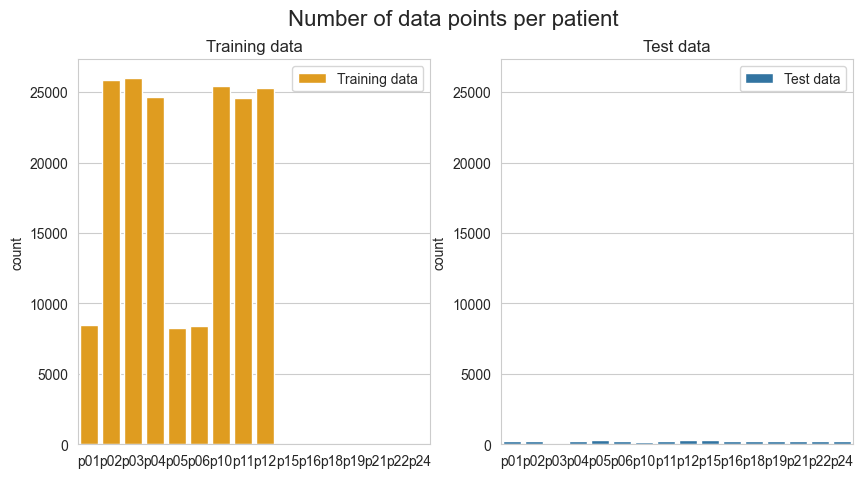

In [6]:
patient_list = sorted(list(set(df_train["p_num"].unique()) | set(df_test["p_num"].unique())))
train_counts = df_train["p_num"].value_counts().reindex(patient_list, fill_value=0)
test_counts = df_test["p_num"].value_counts().reindex(patient_list, fill_value=0)

fig = plt.figure(figsize=(10, 5))
fig.suptitle("Number of data points per patient", fontsize=16)
ax1 = fig.add_subplot(1, 2, 1)
sns.barplot(x=patient_list, y=train_counts, label="Training data", color="orange")
ax1.set_title("Training data")

ax2 = fig.add_subplot(1, 2, 2)
sns.barplot(x=patient_list, y=test_counts, label="Test data")
ax2.set_title("Test data")

# Find the maximum y-axis limit between both plots
y_max = max(ax1.get_ylim()[1], ax2.get_ylim()[1])

# Set the same y-axis limit for both plots
ax1.set_ylim(0, y_max)
ax2.set_ylim(0, y_max)

plt.show();

### Time resolution per patient in training data

In [7]:
patients_train = df_train["p_num"].unique()
patients_train

array(['p01', 'p02', 'p03', 'p04', 'p05', 'p06', 'p10', 'p11', 'p12'],
      dtype=object)

In [8]:
resolutions = pd.DataFrame(columns=["p_num", "time_resolution_in_minutes"])
for patient in patients_train:
    df_patient = df_train[df_train["p_num"] == patient]
    df_patient.loc[:, "time"] = pd.to_datetime(df_patient["time"], format="%H:%M:%S").dt.time

    # Convert time objects to datetime objects (you can choose any date)
    datetime1 = datetime.combine(datetime.today(), df_patient["time"].iloc[0])
    datetime2 = datetime.combine(datetime.today(), df_patient["time"].iloc[1])

    print(datetime1, datetime2)

    # Subtract the datetime objects to get a timedelta
    time_difference = datetime2 - datetime1

    resolutions = pd.concat([
        resolutions,
        pd.DataFrame({"p_num": [patient], "time_resolution_in_minutes": [int(time_difference.seconds / 60)]})
    ], ignore_index=True)

resolutions.head()


2024-10-22 06:10:00 2024-10-22 06:25:00
2024-10-22 06:05:00 2024-10-22 06:10:00
2024-10-22 06:05:00 2024-10-22 06:10:00
2024-10-22 06:05:00 2024-10-22 06:10:00
2024-10-22 06:05:00 2024-10-22 06:20:00
2024-10-22 10:25:00 2024-10-22 10:40:00
2024-10-22 06:05:00 2024-10-22 06:10:00
2024-10-22 06:05:00 2024-10-22 06:10:00
2024-10-22 10:25:00 2024-10-22 10:30:00


,p_num,time_resolution_in_minutes
0,p01,15
1,p02,5
2,p03,5
3,p04,5
4,p05,15


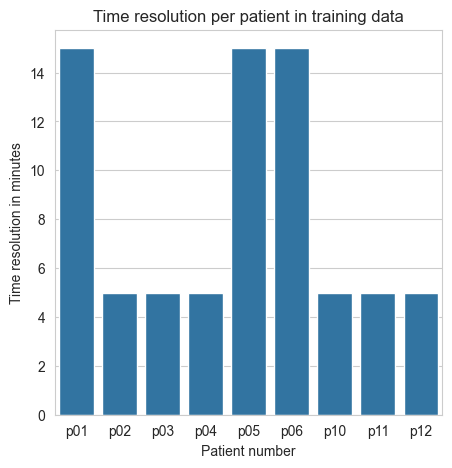

In [9]:
plt.figure(figsize=(5, 5))
sns.barplot(x="p_num", y="time_resolution_in_minutes", data=resolutions)
plt.title("Time resolution per patient in training data")
plt.xlabel("Patient number")
plt.ylabel("Time resolution in minutes")
plt.show()